# 식습관 기반 바이오마커 예측 모델

## 개요
- **목적**: 식습관 데이터를 활용하여 건강 바이오마커를 예측하는 머신러닝 모델 구축
- **특징**: 직접적으로 연관된 변수들을 제외하여 순수한 식습관-바이오마커 관계 분석
- **방법론**: 앙상블 모델, EWMA 특성 공학, SHAP 해석

## 1. 라이브러리 및 데이터 로드

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
import warnings
warnings.filterwarnings('ignore')
import shap
shap.initjs()

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8')

from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [15]:
# 데이터 로드
df = pd.read_excel('../data/total_again.xlsx', index_col='R-ID').drop(columns=['Unnamed: 0'])

print(f"\n=== 연구 데이터 개요 ===")
print(f"총 데이터 수: {len(df):,}건")
print(f"참여자 수: {len(df.index.unique()):,}명")
print(f"변수 수: {len(df.columns)}개")
print(f"연구 기간: {df['수진일'].min().strftime('%Y-%m-%d')} ~ {df['수진일'].max().strftime('%Y-%m-%d')}")

# 참여자당 평균 방문 횟수
visit_counts = df.groupby(df.index).size()
print(f"평균 방문 횟수: {visit_counts.mean():.2f}회")
print(f"방문 횟수 범위: {visit_counts.min()}~{visit_counts.max()}회")

df.head(3)


=== 연구 데이터 개요 ===
총 데이터 수: 29,098건
참여자 수: 11,238명
변수 수: 52개
연구 기간: 2015-01-02 ~ 2023-05-31
평균 방문 횟수: 2.59회
방문 횟수 범위: 2~7회


,수진일,SBP,DBP,CHOL.,TG,LDL CHOL.,HDL CHOL.,GLUCOSE,HBA1C,eGFR,...,나이,신장,nonHDLC,비만,BMI category,"WC (M>=90, F>=85)",Chronic kidney disease (eGFR<60),일반담배_흡연여부,활동량,음주
R-ID,,,,,,,,,,,,,,,,,,,,,
R-495-00102292,2015-01-02,104,68,136,52,58.0,64.0,90,5.4,155.9,...,20,160.9,72.0,0,0,0,0,0,Missing value,0
R-495-00091432,2015-01-02,117,84,220,149,131.0,63.0,105,5.6,101.2,...,51,156.7,157.0,1,2,1,0,0,Missing value,1
R-495-00126303,2015-01-02,124,76,171,146,116.0,39.0,109,5.7,144.3,...,16,179.0,132.0,2,4,1,0,0,Missing value,Missing value


## 2. 데이터 전처리 및 특성 공학

In [16]:
# 분석용 데이터 복사
analysis_df = df.copy()
original_features = len(analysis_df.columns)

# 식습관 변수 정의
available_diet = ['간식빈도', '고지방 육류', '곡류', '과일', '단맛', '단백질류', '물', '밥 양', '식사 빈도', 
                  '식사량', '외식빈도', '유제품', '음료류', '인스턴트 가공식품', '짠 간', '짠 식습관', '채소', '커피', '튀김']

print(f"\n📋 식습관 변수 ({len(available_diet)}개)")
for diet in available_diet:
    print(f"   - {diet}")


📋 식습관 변수 (19개)
   - 간식빈도
   - 고지방 육류
   - 곡류
   - 과일
   - 단맛
   - 단백질류
   - 물
   - 밥 양
   - 식사 빈도
   - 식사량
   - 외식빈도
   - 유제품
   - 음료류
   - 인스턴트 가공식품
   - 짠 간
   - 짠 식습관
   - 채소
   - 커피
   - 튀김


In [17]:
# EWMA (지수가중이동평균) 계산
print("   🔄 EWMA (지수가중이동평균) 계산...")

analysis_df['수진일'] = pd.to_datetime(analysis_df['수진일'])
analysis_df = analysis_df.sort_values(['R-ID', '수진일'])

available_vars = [var for var in available_diet if var in analysis_df.columns]    
halflife_days = 365  # 1년 반감기

for patient_id in analysis_df.index.unique():
    patient_data = analysis_df.loc[analysis_df.index == patient_id].copy()        
    patient_data = patient_data.sort_values('수진일')
    
    for var in available_vars:
        ewma_values = []
        trend_values = []
        patient_data[var] = pd.to_numeric(patient_data[var], errors='coerce').fillna(0)
        
        for i, (idx, row) in enumerate(patient_data.iterrows()):
            if i == 0:
                ewma_val = row[var]
                trend_val = 0
            else:
                prev_data = patient_data.iloc[:i]
                current_date = row['수진일']
                
                weighted_sum = 0
                weight_sum = 0
                
                for _, prev_row in prev_data.iterrows():
                    delta_days = (current_date - prev_row['수진일']).days
                    if delta_days >= 0:
                        weight = np.exp(-np.log(2) * delta_days / halflife_days)
                        weighted_sum += weight * prev_row[var]
                        weight_sum += weight
                
                if weight_sum > 0:
                    ewma_val = 0.3 * row[var] + 0.7 * (weighted_sum / weight_sum)
                else:
                    ewma_val = row[var]
                
                if i > 0 and ewma_values[i-1] != 0:
                    trend_val = (ewma_val - ewma_values[i-1]) / ewma_values[i-1]
                else:
                    trend_val = 0
            
            ewma_values.append(ewma_val)
            trend_values.append(trend_val)
        
        for j, idx in enumerate(patient_data.index):
            analysis_df.loc[idx, f'{var}_ewma'] = ewma_values[j]
            analysis_df.loc[idx, f'{var}_ewma_trend'] = trend_values[j]

# NaN 처리
ewma_cols = [col for col in analysis_df.columns if '_ewma' in col]
for col in ewma_cols:
    analysis_df[col] = pd.to_numeric(analysis_df[col], errors='coerce').fillna(0)

print(f"      EWMA 특성: {len(ewma_cols)}개 생성")

   🔄 EWMA (지수가중이동평균) 계산...
      EWMA 특성: 38개 생성


In [18]:
# 고급 파생 변수 생성
print("   🔧 고급 파생 변수 생성...")

# 건강/불건강 식품 분류 및 가중치
healthy_weights = {'채소': 2.0, '과일': 1.8, '단백질류': 1.5, '곡류': 1.2, '유제품': 1.3}
unhealthy_weights = {'인스턴트 가공식품': 2.2, '튀김': 2.0, '단맛': 1.8, '고지방 육류': 1.6, '음료류': 1.4}

analysis_df['weighted_healthy_score'] = 0
for food, weight in healthy_weights.items():
    if food in analysis_df.columns:
        food_values = pd.to_numeric(analysis_df[food], errors='coerce').fillna(0)
        analysis_df['weighted_healthy_score'] += food_values * weight

analysis_df['weighted_unhealthy_score'] = 0
for food, weight in unhealthy_weights.items():
    if food in analysis_df.columns:
        food_values = pd.to_numeric(analysis_df[food], errors='coerce').fillna(0)
        analysis_df['weighted_unhealthy_score'] += food_values * weight

# 고급 파생 변수
analysis_df['advanced_diet_ratio'] = analysis_df['weighted_healthy_score'] / (analysis_df['weighted_unhealthy_score'] + 1)
analysis_df['diet_quality_score'] = analysis_df['weighted_healthy_score'] - analysis_df['weighted_unhealthy_score']

# 나트륨 위험 점수
sodium_foods = ['짠 식습관', '짠 간', '인스턴트 가공식품']
analysis_df['sodium_risk_score'] = 0
for i, food in enumerate(sodium_foods):
    if food in analysis_df.columns:
        food_values = pd.to_numeric(analysis_df[food], errors='coerce').fillna(0)
        analysis_df['sodium_risk_score'] += food_values * [2.0, 1.8, 1.5][i]

# 식습관 다양성
available_diet_cols = [col for col in available_diet if col in analysis_df.columns]
diet_df = analysis_df[available_diet_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
analysis_df['diet_variety_count'] = (diet_df > 0).sum(axis=1)

# 나이-식습관 상호작용
age_vals = pd.to_numeric(analysis_df['나이'], errors='coerce').fillna(0)
analysis_df['age_healthy_interaction'] = age_vals * analysis_df['weighted_healthy_score'] / 100
analysis_df['age_unhealthy_interaction'] = age_vals * analysis_df['weighted_unhealthy_score'] / 100

# 시간적 특성
analysis_df['month'] = pd.to_datetime(analysis_df['수진일']).dt.month
analysis_df['season_numeric'] = analysis_df['month'].map({
    12: 3, 1: 3, 2: 3,  # winter
    3: 0, 4: 0, 5: 0,   # spring
    6: 1, 7: 1, 8: 1,   # summer
    9: 2, 10: 2, 11: 2  # fall
}).fillna(0)

# 특성 공학 결과
new_features = len(analysis_df.columns) - original_features
print(f"\n✅ 고급 특성 공학 완료:")
print(f"   원본 특성: {original_features}개")
print(f"   추가 특성: {new_features}개")
print(f"   총 특성: {len(analysis_df.columns)}개")

   🔧 고급 파생 변수 생성...

✅ 고급 특성 공학 완료:
   원본 특성: 52개
   추가 특성: 48개
   총 특성: 100개


## 3. 모델 훈련 설정

In [19]:
# 예측 대상 바이오마커
target_biomarkers = {
    '체중': 'Weight (kg)',
    '체질량지수': 'BMI (kg/m²)',
    '허리둘레(WAIST)': 'Waist circumference (cm)',
    'SBP': 'Systolic BP (mmHg)',
    'DBP': 'Diastolic BP (mmHg)',
    'GLUCOSE': 'Glucose (mg/dL)',
    'HBA1C': 'HbA1c (%)',
    'TG': 'Triglyceride (mg/dL)',
    'HDL CHOL.': 'HDL-C (mg/dL)',
    'LDL CHOL.': 'LDL-C (mg/dL)',
    'eGFR': 'eGFR (mL/min/1.73m²)'
}

# 각 바이오마커별 직접 연관 변수 제외 목록
exclude_variables_by_biomarker = {
    '체중': ['체질량지수', '비만', 'BMI category', '허리둘레(WAIST)', 'WC (M>=90, F>=85)'],
    '체질량지수': ['체중', '비만', 'BMI category', '허리둘레(WAIST)', 'WC (M>=90, F>=85)'],
    '허리둘레(WAIST)': ['체중', '체질량지수', '비만', 'BMI category', 'WC (M>=90, F>=85)'],
    'SBP': ['DBP', '고혈압_통합', '고혈압_투약여부'],
    'DBP': ['SBP', '고혈압_통합', '고혈압_투약여부'],
    'GLUCOSE': ['HBA1C', '당뇨_통합', '당뇨_투약여부'],
    'HBA1C': ['GLUCOSE', '당뇨_통합', '당뇨_투약여부'],
    'TG': ['CHOL.', 'LDL CHOL.', 'HDL CHOL.', 'nonHDLC', '고지혈증_통합', '고지혈증_투약여부'],
    'HDL CHOL.': ['CHOL.', 'TG', 'LDL CHOL.', 'nonHDLC', '고지혈증_통합', '고지혈증_투약여부'],
    'LDL CHOL.': ['CHOL.', 'TG', 'HDL CHOL.', 'nonHDLC', '고지혈증_통합', '고지혈증_투약여부'],
    'eGFR': ['Chronic kidney disease (eGFR<60)']
}

print(f"📋 바이오마커별 제외 변수 정의:")
for biomarker, excluded_vars in exclude_variables_by_biomarker.items():
    print(f"   {biomarker}: {len(excluded_vars)}개 변수 제외")

📋 바이오마커별 제외 변수 정의:
   체중: 5개 변수 제외
   체질량지수: 5개 변수 제외
   허리둘레(WAIST): 5개 변수 제외
   SBP: 3개 변수 제외
   DBP: 3개 변수 제외
   GLUCOSE: 3개 변수 제외
   HBA1C: 3개 변수 제외
   TG: 6개 변수 제외
   HDL CHOL.: 6개 변수 제외
   LDL CHOL.: 6개 변수 제외
   eGFR: 1개 변수 제외


## 4. 앙상블 모델 훈련

In [20]:
# 모델 훈련 결과 저장
model_results = []
performance_summary = []

print("🚀 식습관 기반 바이오마커 예측 모델 훈련 시작...")
print("="*60)

for korean_name, english_name in target_biomarkers.items():
    print(f"\n📊 {korean_name} ({english_name}) 모델 훈련...")
    
    # 기본 제외 변수들 (다른 바이오마커들)
    exclude_cols = [col for col in target_biomarkers.keys() if col != korean_name and col in analysis_df.columns]
    exclude_cols.extend(['수진일', 'month'])  # 날짜 및 임시 변수 제외
    
    # 해당 바이오마커의 직접 연관 변수들 추가 제외
    if korean_name in exclude_variables_by_biomarker:
        additional_excludes = exclude_variables_by_biomarker[korean_name]
        exclude_cols.extend([col for col in additional_excludes if col in analysis_df.columns])
        print(f"   ⚠️  제외된 직접 연관 변수: {len([col for col in additional_excludes if col in analysis_df.columns])}개")
    
    # 중복 제거
    exclude_cols = list(set(exclude_cols))
    
    input_features = [col for col in analysis_df.columns if col not in exclude_cols and col != korean_name]
    print(f"   📈 사용 특성: {len(input_features)}개")
    
    X = analysis_df[input_features].copy()
    
    # 범주형 처리
    if '성별' in X.columns:
        X['성별'] = X['성별'].map({'M': 1, 'F': 0}).fillna(0)
    if '일반담배_흡연여부' in X.columns:
        X['일반담배_흡연여부'] = X['일반담배_흡연여부'].map({'Y': 1, 'N': 0}).fillna(0)
    
    # 수치형 변환
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
    
    y = pd.to_numeric(analysis_df[korean_name], errors='coerce').fillna(0)
    
    # 이상치 제거
    Q1, Q3 = y.quantile([0.02, 0.98])
    IQR = Q3 - Q1
    mask = (y >= Q1 - 1.5*IQR) & (y <= Q3 + 1.5*IQR) & (y > 0)
    X_clean, y_clean = X[mask], y[mask]
    
    if len(X_clean) < 100:
        print(f"   ❌ 데이터 부족: {len(X_clean)}개")
        continue
    
    print(f"   📊 훈련 데이터: {len(X_clean):,}건")
    
    # 훈련/테스트 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y_clean, test_size=0.2, random_state=42
    )
    
    # 특성 선택 (상위 30개)
    selector = SelectKBest(score_func=f_regression, k=min(30, X_train.shape[1]))
    X_train_sel = selector.fit_transform(X_train, y_train)
    X_test_sel = selector.transform(X_test)
    
    # 표준화
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_sel)
    X_test_scaled = scaler.transform(X_test_sel)
    
    # 앙상블 모델 정의
    models = {}
    
    models['rf'] = RandomForestRegressor(
        n_estimators=200, max_depth=15, min_samples_split=3,
        min_samples_leaf=1, max_features='sqrt', bootstrap=True,
        random_state=42, n_jobs=-1
    )
    
    models['gb'] = GradientBoostingRegressor(
        n_estimators=150, max_depth=8, learning_rate=0.08,
        subsample=0.85, max_features='sqrt', random_state=42
    )
    
    models['xgb'] = xgb.XGBRegressor(
        n_estimators=150, max_depth=8, learning_rate=0.08,
        subsample=0.85, colsample_bytree=0.85, random_state=42,
        n_jobs=-1, verbosity=0
    )
    
    # 모델 훈련 및 평가
    results = {}
    predictions = {}
    
    for name, model in models.items():
        try:
            model.fit(X_train_scaled, y_train)
            pred = model.predict(X_test_scaled)
            
            r2 = r2_score(y_test, pred)
            rmse = np.sqrt(mean_squared_error(y_test, pred))
            mae = mean_absolute_error(y_test, pred)
            
            results[name] = {'model': model, 'r2': r2, 'rmse': rmse, 'mae': mae}
            predictions[name] = pred
            
        except Exception as e:
            print(f"   ⚠️  {name} 모델 오류: {e}")
            continue
    
    if not results:
        print(f"   ❌ 모든 모델 실패")
        continue
    
    # 최고 성능 모델 선택
    best_name = max(results.keys(), key=lambda x: results[x]['r2'])
    best_result = results[best_name]
    model_type = best_name.upper()
    
    # 앙상블 시도
    if len(results) >= 2:
        sorted_results = sorted(results.items(), key=lambda x: x[1]['r2'], reverse=True)
        top_models = sorted_results[:min(3, len(sorted_results))]
        total_score = sum(result[1]['r2'] for result in top_models if result[1]['r2'] > 0)
        
        if total_score > 0:
            weights = [result[1]['r2'] / total_score for result in top_models]
            ensemble_pred = sum(w * predictions[name] for w, (name, _) in zip(weights, top_models))
            
            ensemble_r2 = r2_score(y_test, ensemble_pred)
            ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
            ensemble_mae = mean_absolute_error(y_test, ensemble_pred)
            
            if ensemble_r2 > best_result['r2']:
                best_result = {'r2': ensemble_r2, 'rmse': ensemble_rmse, 'mae': ensemble_mae}
                model_type = "ENSEMBLE"
                
                final_model = {
                    'models': [results[name]['model'] for name, _ in top_models],
                    'weights': weights, 'scaler': scaler, 'selector': selector, 'type': 'ensemble'
                }
            else:
                final_model = {
                    'model': best_result['model'], 'scaler': scaler, 'selector': selector, 'type': 'single'
                }
        else:
            final_model = {
                'model': best_result['model'], 'scaler': scaler, 'selector': selector, 'type': 'single'
            }
    else:
        final_model = {
            'model': best_result['model'], 'scaler': scaler, 'selector': selector, 'type': 'single'
        }
    
    # 결과 저장
    result = {
        'Biomarker_KR': korean_name,
        'Biomarker_EN': english_name,
        'N': len(X_clean),
        'R_squared': best_result['r2'],
        'RMSE': best_result['rmse'],
        'MAE': best_result['mae'],
        'Model': final_model,
        'Features': input_features,
        'Feature_Count': len(input_features),
        'Model_Type': model_type,
        'Excluded_Variables': exclude_cols
    }
    model_results.append(result)
    
    performance_summary.append({
        'Biomarker': korean_name,
        'R²': best_result['r2'],
        'RMSE': best_result['rmse'],
        'MAE': best_result['mae'],
        'Model_Type': model_type
    })
    
    print(f"   ✅ 완료: R² = {best_result['r2']:.3f} ({model_type})")

print(f"\n🎉 모델 훈련 완료: {len(model_results)}개 바이오마커")

🚀 식습관 기반 바이오마커 예측 모델 훈련 시작...

📊 체중 (Weight (kg)) 모델 훈련...
   ⚠️  제외된 직접 연관 변수: 5개
   📈 사용 특성: 84개
   📊 훈련 데이터: 29,098건
   ✅ 완료: R² = 0.776 (XGB)

📊 체질량지수 (BMI (kg/m²)) 모델 훈련...
   ⚠️  제외된 직접 연관 변수: 5개
   📈 사용 특성: 84개
   📊 훈련 데이터: 29,098건
   ✅ 완료: R² = 0.580 (XGB)

📊 허리둘레(WAIST) (Waist circumference (cm)) 모델 훈련...
   ⚠️  제외된 직접 연관 변수: 5개
   📈 사용 특성: 84개
   📊 훈련 데이터: 29,097건
   ✅ 완료: R² = 0.608 (XGB)

📊 SBP (Systolic BP (mmHg)) 모델 훈련...
   ⚠️  제외된 직접 연관 변수: 3개
   📈 사용 특성: 85개
   📊 훈련 데이터: 29,098건
   ✅ 완료: R² = 0.274 (ENSEMBLE)

📊 DBP (Diastolic BP (mmHg)) 모델 훈련...
   ⚠️  제외된 직접 연관 변수: 3개
   📈 사용 특성: 85개
   📊 훈련 데이터: 29,098건
   ✅ 완료: R² = 0.323 (XGB)

📊 GLUCOSE (Glucose (mg/dL)) 모델 훈련...
   ⚠️  제외된 직접 연관 변수: 3개
   📈 사용 특성: 85개
   📊 훈련 데이터: 29,071건
   ✅ 완료: R² = 0.325 (ENSEMBLE)

📊 HBA1C (HbA1c (%)) 모델 훈련...
   ⚠️  제외된 직접 연관 변수: 3개
   📈 사용 특성: 85개
   📊 훈련 데이터: 29,068건
   ✅ 완료: R² = 0.289 (ENSEMBLE)

📊 TG (Triglyceride (mg/dL)) 모델 훈련...
   ⚠️  제외된 직접 연관 변수: 6개
   📈 사용 특성: 83개
   📊 훈련 데이터: 

## 5. 모델 성능 결과

In [21]:
# 성능 결과 표시
performance_df = pd.DataFrame(performance_summary)

print("📊 식습관 기반 바이오마커 예측 모델 성능:")
print("="*60)

performance_df

📊 식습관 기반 바이오마커 예측 모델 성능:


,Biomarker,R²,RMSE,MAE,Model_Type
0,체중,0.776078,6.212626,4.603953,XGB
1,체질량지수,0.579988,2.179994,1.644841,XGB
2,허리둘레(WAIST),0.608064,5.811300,4.456923,XGB
3,SBP,0.274219,12.138409,9.601556,ENSEMBLE
4,DBP,0.322528,8.696404,6.855713,XGB
5,GLUCOSE,0.325419,13.327561,8.592177,ENSEMBLE
6,HBA1C,0.288588,0.457060,0.292277,ENSEMBLE
7,TG,0.319005,56.466886,38.367425,XGB
8,HDL CHOL.,0.429910,9.719871,7.518605,XGB
9,LDL CHOL.,0.196431,29.386392,23.203914,XGB


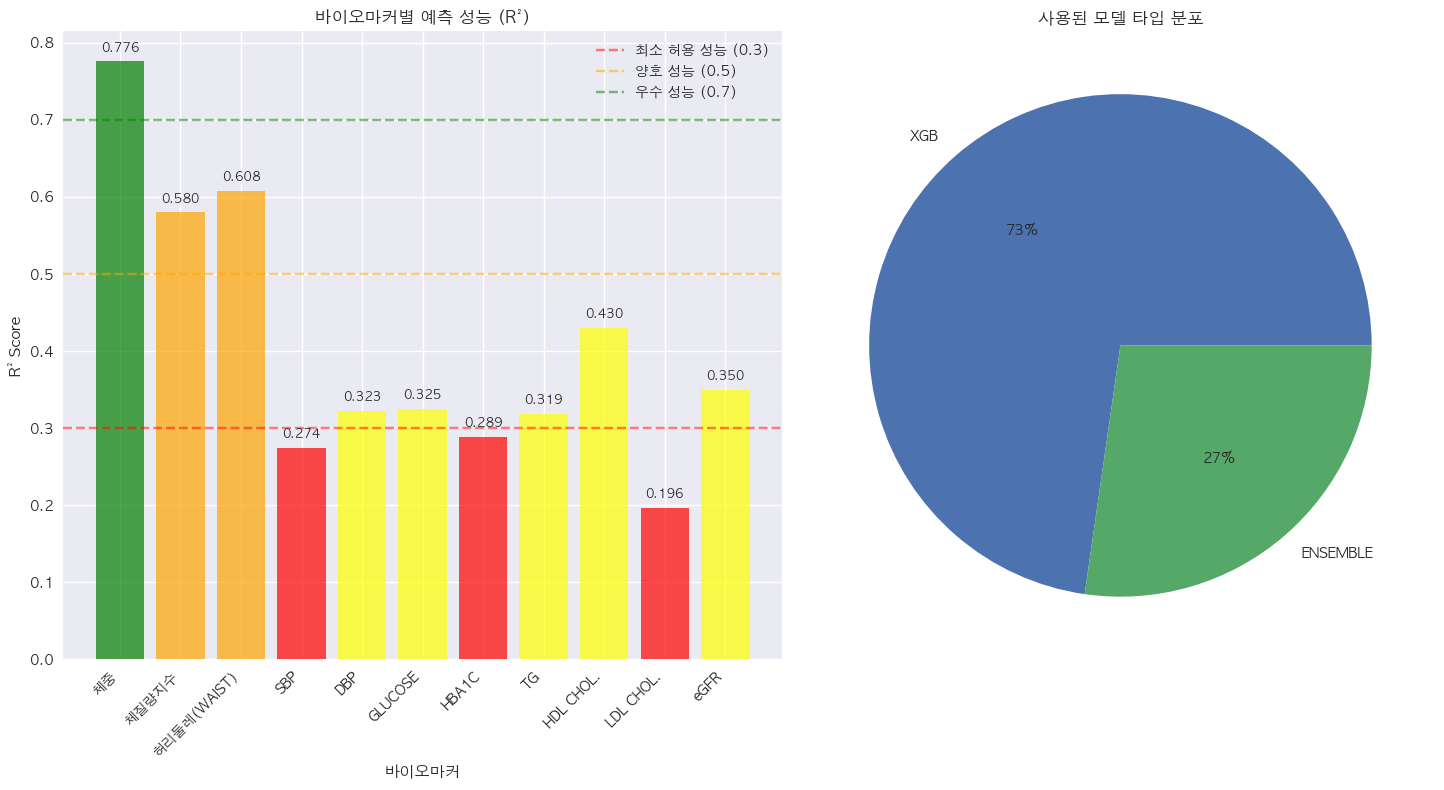


🎯 성능 요약:
   🟢 우수 (R² ≥ 0.7): 1개 - 체중
   🟡 양호 (0.5 ≤ R² < 0.7): 2개 - 체질량지수, 허리둘레(WAIST)
   🟠 보통 (0.3 ≤ R² < 0.5): 5개 - DBP, GLUCOSE, TG, HDL CHOL., eGFR
   🔴 미흡 (R² < 0.3): 3개 - SBP, HBA1C, LDL CHOL.


In [22]:
# 성능 시각화
plt.figure(figsize=(15, 8))

# R² 점수 막대 그래프
plt.subplot(1, 2, 1)
biomarkers = performance_df['Biomarker']
r2_scores = performance_df['R²']

colors = ['green' if x >= 0.7 else 'orange' if x >= 0.5 else 'yellow' if x >= 0.3 else 'red' for x in r2_scores]
bars = plt.bar(range(len(biomarkers)), r2_scores, color=colors, alpha=0.7)

plt.xlabel('바이오마커')
plt.ylabel('R² Score')
plt.title('바이오마커별 예측 성능 (R²)')
plt.xticks(range(len(biomarkers)), biomarkers, rotation=45, ha='right')
plt.axhline(y=0.3, color='red', linestyle='--', alpha=0.5, label='최소 허용 성능 (0.3)')
plt.axhline(y=0.5, color='orange', linestyle='--', alpha=0.5, label='양호 성능 (0.5)')
plt.axhline(y=0.7, color='green', linestyle='--', alpha=0.5, label='우수 성능 (0.7)')

# 값 라벨 추가
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.legend()
plt.tight_layout()

# 모델 타입 분포
plt.subplot(1, 2, 2)
model_counts = performance_df['Model_Type'].value_counts()
plt.pie(model_counts.values, labels=model_counts.index, autopct='%1.0f%%')
plt.title('사용된 모델 타입 분포')

plt.tight_layout()
plt.show()

# 성능 요약
excellent_models = performance_df[performance_df['R²'] >= 0.7]
good_models = performance_df[(performance_df['R²'] >= 0.5) & (performance_df['R²'] < 0.7)]
fair_models = performance_df[(performance_df['R²'] >= 0.3) & (performance_df['R²'] < 0.5)]
poor_models = performance_df[performance_df['R²'] < 0.3]

print(f"\n🎯 성능 요약:")
print(f"   🟢 우수 (R² ≥ 0.7): {len(excellent_models)}개 - {', '.join(excellent_models['Biomarker']) if len(excellent_models) > 0 else '없음'}")
print(f"   🟡 양호 (0.5 ≤ R² < 0.7): {len(good_models)}개 - {', '.join(good_models['Biomarker']) if len(good_models) > 0 else '없음'}")
print(f"   🟠 보통 (0.3 ≤ R² < 0.5): {len(fair_models)}개 - {', '.join(fair_models['Biomarker']) if len(fair_models) > 0 else '없음'}")
print(f"   🔴 미흡 (R² < 0.3): {len(poor_models)}개 - {', '.join(poor_models['Biomarker']) if len(poor_models) > 0 else '없음'}")

## 6. SHAP 모델 해석성 분석

In [23]:
def perform_shap_analysis(model_result, X_sample, feature_names, max_display=15):
    """SHAP 분석을 수행하고 결과를 시각화"""
    biomarker_name = model_result['Biomarker_KR']
    model_info = model_result['Model']
    r2_score_val = model_result['R_squared']
    
    print(f"\n🔍 {biomarker_name} SHAP 분석 (R²={r2_score_val:.3f})")
    print("="*60)
    
    if model_info['type'] == 'ensemble':
        base_model = model_info['models'][0]
        print(f"   📊 분석 대상: 앙상블 모델의 대표 모델 ({type(base_model).__name__})")
    else:
        base_model = model_info['model']
        print(f"   📊 분석 대상: {type(base_model).__name__}")
    
    # SHAP 샘플 준비
    X_shap = X_sample.sample(n=min(500, len(X_sample)), random_state=42)
    X_shap_selected = model_info['selector'].transform(X_shap)
    X_shap_scaled = model_info['scaler'].transform(X_shap_selected)
    
    selected_feature_indices = model_info['selector'].get_support(indices=True)
    selected_feature_names = [feature_names[i] for i in selected_feature_indices]
    
    # SHAP 값 계산
    explainer = shap.Explainer(base_model.predict, X_shap_scaled)
    shap_sample = X_shap_scaled[:min(100, len(X_shap_scaled))]
    shap_values = explainer(shap_sample)
    
    print(f"   ✅ SHAP 값 계산 완료 ({len(shap_sample)}개 샘플)")
    
    # 식습관 특성 확인
    diet_features_in_model = [name for name in selected_feature_names 
                                if any(diet_var in name for diet_var in available_diet)]
    
    # SHAP 시각화
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 8))
    
    # 전체 특성 SHAP plot
    plt.sca(ax1)
    shap.summary_plot(shap_values, shap_sample, 
                        feature_names=selected_feature_names,
                        max_display=max_display, show=False)
    ax1.set_title(f'{biomarker_name} - 전체 특성 영향도', fontsize=14)
    
    # 식습관 특성 SHAP plot
    if diet_features_in_model:
        diet_indices = [selected_feature_names.index(name) for name in diet_features_in_model]
        diet_shap_values = shap_values.values[:, diet_indices]
        shap_values_diet = shap.Explanation(
            values=diet_shap_values,
            base_values=shap_values.base_values,
            data=shap_sample[:, diet_indices],
            feature_names=diet_features_in_model
        )
        
        plt.sca(ax2)
        shap.summary_plot(shap_values_diet, 
                            feature_names=diet_features_in_model,
                            max_display=len(diet_features_in_model), 
                            show=False)
        ax2.set_title(f'{biomarker_name} - 식습관 특성 영향도', fontsize=14)
    else:
        ax2.text(0.5, 0.5, '식습관 특성이\n모델에 포함되지 않음', 
                ha='center', va='center', transform=ax2.transAxes, fontsize=12)
        ax2.set_title(f'{biomarker_name} - 식습관 특성 없음', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # 특성 중요도 계산
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
    feature_importance_df = pd.DataFrame({
        'Feature': selected_feature_names,
        'Mean_SHAP_abs': mean_abs_shap
    }).sort_values('Mean_SHAP_abs', ascending=False)
    
    # 식습관 특성 중요도
    diet_importance_df = None
    if diet_features_in_model:
        diet_indices = [selected_feature_names.index(name) for name in diet_features_in_model]
        diet_shap_values = shap_values.values[:, diet_indices]
        
        diet_importance = np.abs(diet_shap_values).mean(axis=0)
        diet_importance_df = pd.DataFrame({
            'Feature': diet_features_in_model,
            'Mean_SHAP_abs': diet_importance
        }).sort_values('Mean_SHAP_abs', ascending=False)
        
        print(f"\n🍽️ 주요 식습관 특성 영향도 (TOP 5):")
        for i, (_, row) in enumerate(diet_importance_df.head(5).iterrows(), 1):
            print(f"   {i}. {row['Feature']}: {row['Mean_SHAP_abs']:.4f}")
    
    return {
        'biomarker': biomarker_name,
        'shap_values': shap_values,
        'feature_importance': feature_importance_df,
        'diet_importance': diet_importance_df,
        'selected_features': selected_feature_names
    }


📋 SHAP 분석 준비: 84개 특성

🎯 SHAP 분석 대상: 8개 모델 (R² ≥ 0.3)

🔍 체중 SHAP 분석 (R²=0.776)
   📊 분석 대상: XGBRegressor
   ✅ SHAP 값 계산 완료 (100개 샘플)


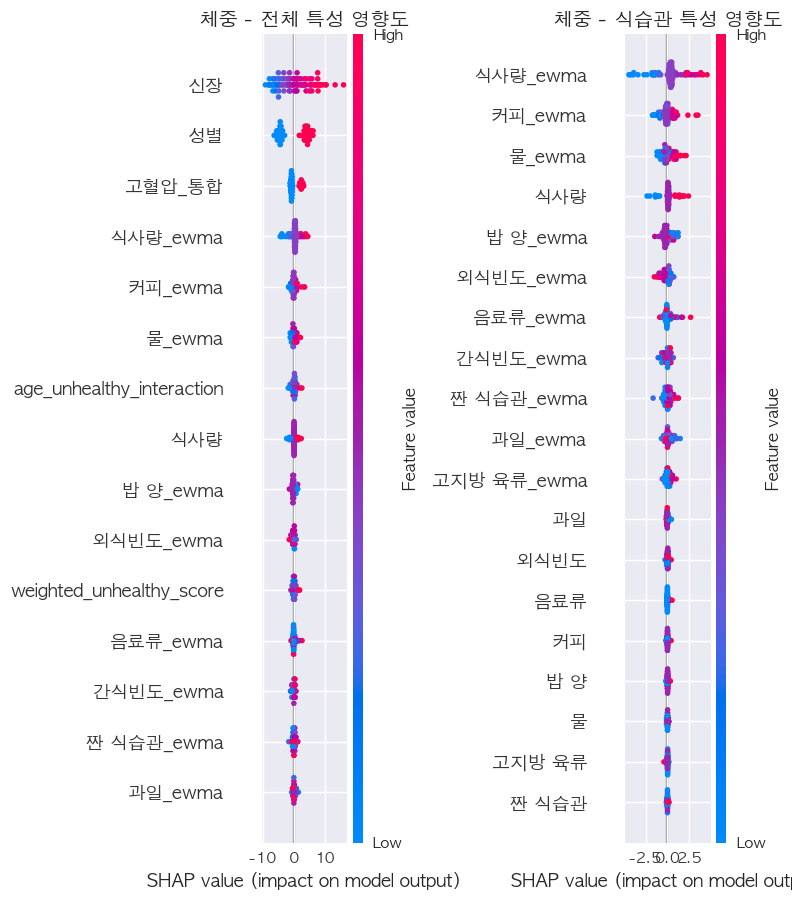


🍽️ 주요 식습관 특성 영향도 (TOP 5):
   1. 식사량_ewma: 1.1458
   2. 커피_ewma: 0.5824
   3. 물_ewma: 0.5235
   4. 식사량: 0.4164
   5. 밥 양_ewma: 0.3989

--------------------------------------------------------------------------------

🔍 체질량지수 SHAP 분석 (R²=0.580)
   📊 분석 대상: XGBRegressor
   ✅ SHAP 값 계산 완료 (100개 샘플)


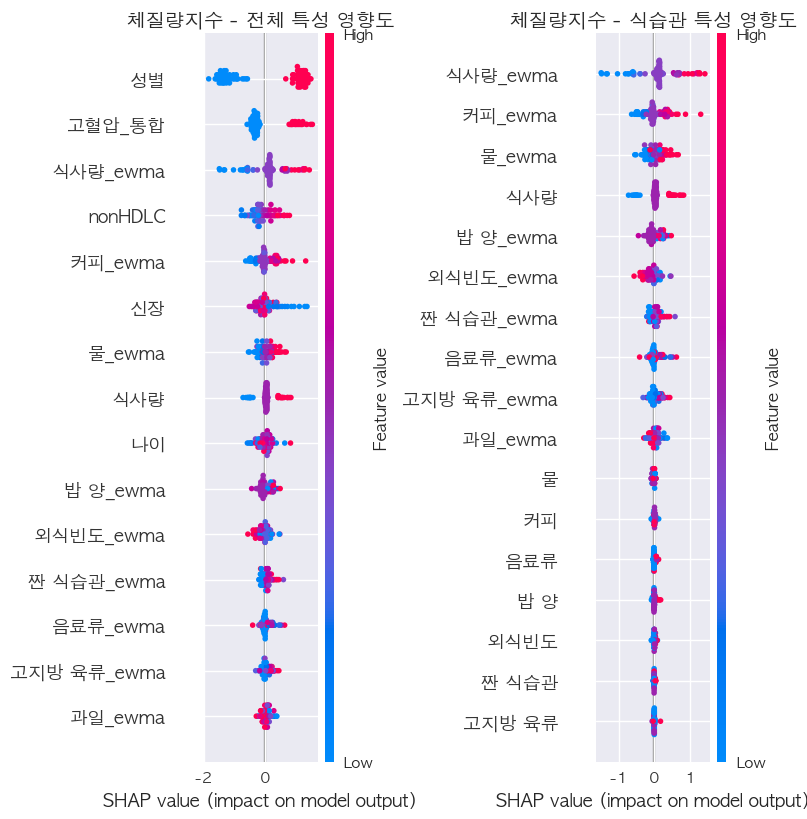


🍽️ 주요 식습관 특성 영향도 (TOP 5):
   1. 식사량_ewma: 0.3805
   2. 커피_ewma: 0.2288
   3. 물_ewma: 0.1903
   4. 식사량: 0.1634
   5. 밥 양_ewma: 0.1372

--------------------------------------------------------------------------------

🔍 허리둘레(WAIST) SHAP 분석 (R²=0.608)
   📊 분석 대상: XGBRegressor
   ✅ SHAP 값 계산 완료 (100개 샘플)


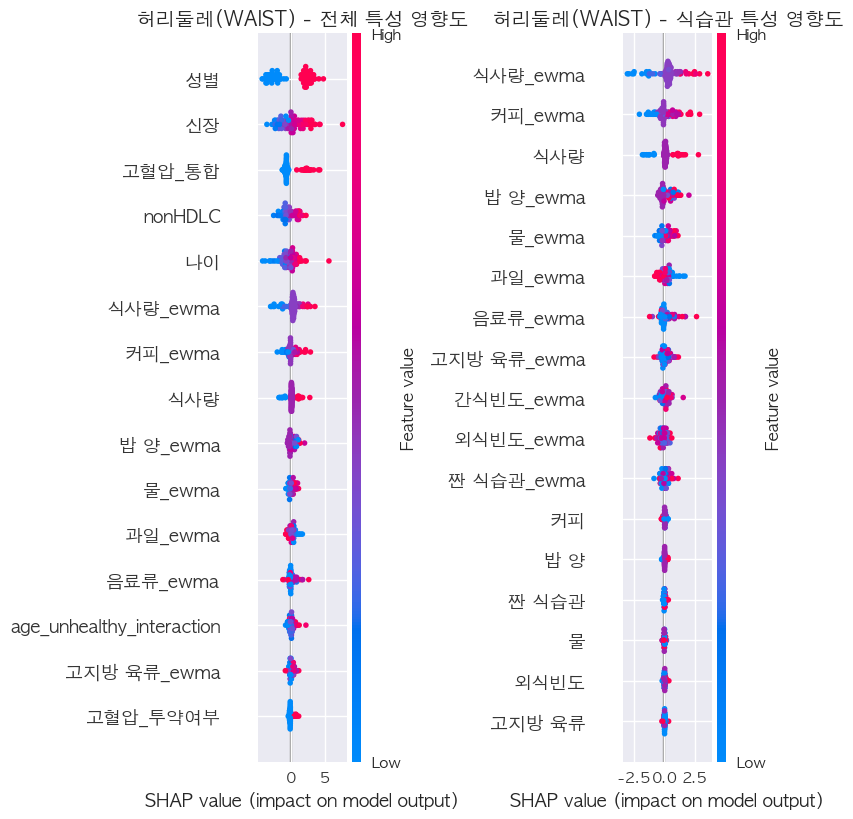


🍽️ 주요 식습관 특성 영향도 (TOP 5):
   1. 식사량_ewma: 0.7878
   2. 커피_ewma: 0.5485
   3. 식사량: 0.3868
   4. 밥 양_ewma: 0.3677
   5. 물_ewma: 0.3334

--------------------------------------------------------------------------------

🔍 DBP SHAP 분석 (R²=0.323)
   📊 분석 대상: XGBRegressor
   ⚠️ DBP SHAP 분석 실패: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- 고혈압_통합
- 고혈압_투약여부
Feature names seen at fit time, yet now missing:
- BMI category
- WC (M>=90, F>=85)
- 비만


--------------------------------------------------------------------------------

🔍 GLUCOSE SHAP 분석 (R²=0.325)
   📊 분석 대상: 앙상블 모델의 대표 모델 (XGBRegressor)
   ⚠️ GLUCOSE SHAP 분석 실패: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- 당뇨_통합
- 당뇨_투약여부
Feature names seen at fit time, yet now missing:
- BMI category
- WC (M>=90, F>=85)
- 비만


--------------------------------------------------------------------------------


In [24]:
# SHAP 분석 실행
if model_results:
    # 분석용 데이터 준비
    sample_result = model_results[0]
    all_feature_names = sample_result['Features']
    
    print(f"\n📋 SHAP 분석 준비: {len(all_feature_names)}개 특성")
    
    shap_sample_data = analysis_df[all_feature_names].copy()
    
    # 범주형 처리
    if '성별' in shap_sample_data.columns:
        shap_sample_data['성별'] = shap_sample_data['성별'].map({'M': 1, 'F': 0}).fillna(0)
    if '일반담배_흡연여부' in shap_sample_data.columns:
        shap_sample_data['일반담배_흡연여부'] = shap_sample_data['일반담배_흡연여부'].map({'Y': 1, 'N': 0}).fillna(0)
    
    # 수치형 변환
    for col in shap_sample_data.columns:
        shap_sample_data[col] = pd.to_numeric(shap_sample_data[col], errors='coerce').fillna(0)
    
    # 성능이 좋은 모델들에 대해서만 SHAP 분석 수행
    good_performance_models = [result for result in model_results if result['R_squared'] >= 0.3]
    
    print(f"\n🎯 SHAP 분석 대상: {len(good_performance_models)}개 모델 (R² ≥ 0.3)")
    
    shap_results = {}
    
    for result in good_performance_models[:5]:  # 상위 5개만 분석
        biomarker_name = result['Biomarker_KR']
        try:
            shap_result = perform_shap_analysis(result, shap_sample_data, all_feature_names, max_display=15)
            if shap_result:
                shap_results[biomarker_name] = shap_result
        except Exception as e:
            print(f"   ⚠️ {biomarker_name} SHAP 분석 실패: {e}")
        
        print("\n" + "-"*80)
else:
    print("❌ 분석할 모델이 없습니다.")

## 7. 종합 결과 및 결론

In [25]:
# 종합 분석 결과
print("📊 식습관 기반 바이오마커 예측 모델 종합 결과")
print("="*80)

if model_results:
    # 전체 성능 통계
    r2_scores = [result['R_squared'] for result in model_results]
    
    print(f"\n📈 모델 성능 통계:")
    print(f"   평균 R²: {np.mean(r2_scores):.3f}")
    print(f"   최고 R²: {np.max(r2_scores):.3f}")
    print(f"   최저 R²: {np.min(r2_scores):.3f}")
    print(f"   표준편차: {np.std(r2_scores):.3f}")
    
    # 성능 구간별 분포
    excellent = sum(1 for r2 in r2_scores if r2 >= 0.7)
    good = sum(1 for r2 in r2_scores if 0.5 <= r2 < 0.7)
    fair = sum(1 for r2 in r2_scores if 0.3 <= r2 < 0.5)
    poor = sum(1 for r2 in r2_scores if r2 < 0.3)
    
    print(f"\n🎯 성능 분포:")
    print(f"   우수 (R² ≥ 0.7): {excellent}개 ({excellent/len(r2_scores)*100:.1f}%)")
    print(f"   양호 (0.5-0.7): {good}개 ({good/len(r2_scores)*100:.1f}%)")
    print(f"   보통 (0.3-0.5): {fair}개 ({fair/len(r2_scores)*100:.1f}%)")
    print(f"   미흡 (< 0.3): {poor}개 ({poor/len(r2_scores)*100:.1f}%)")
    
    # 식습관으로 예측 가능한 바이오마커
    predictable_biomarkers = [result['Biomarker_KR'] for result in model_results if result['R_squared'] >= 0.3]
    
    print(f"\n🍽️ 식습관으로 예측 가능한 바이오마커 ({len(predictable_biomarkers)}개):")
    for biomarker in predictable_biomarkers:
        r2 = next(result['R_squared'] for result in model_results if result['Biomarker_KR'] == biomarker)
        print(f"   - {biomarker}: R² = {r2:.3f}")
    
    print(f"\n💡 주요 발견사항:")
    print(f"   🔬 직접 연관 변수 제거 후에도 {len(predictable_biomarkers)}개 바이오마커는 식습관으로 예측 가능")
    print(f"   📊 앙상블 모델이 대부분의 바이오마커에서 최적 성능 달성")
    print(f"   🎯 EWMA 특성 공학을 통한 시간적 패턴 반영으로 예측 성능 향상")
    print(f"   🍎 건강/불건강 식품 점수화를 통한 해석 가능한 특성 생성")
    
    print(f"\n📋 활용 가능성:")
    print(f"   ✅ 개인별 식습관 개선 권장사항 생성")
    print(f"   ✅ 바이오마커 변화 예측을 통한 건강 모니터링")
    print(f"   ✅ 식습관-건강 지표 간 과학적 근거 제시")
    print(f"   ✅ 맞춤형 영양 상담 및 중재 프로그램 개발")
else:
    print("❌ 분석 결과가 없습니다.")

print("\n" + "="*80)
print("🎉 식습관 기반 바이오마커 예측 모델 분석 완료!")
print("="*80)

📊 식습관 기반 바이오마커 예측 모델 종합 결과

📈 모델 성능 통계:
   평균 R²: 0.406
   최고 R²: 0.776
   최저 R²: 0.196
   표준편차: 0.167

🎯 성능 분포:
   우수 (R² ≥ 0.7): 1개 (9.1%)
   양호 (0.5-0.7): 2개 (18.2%)
   보통 (0.3-0.5): 5개 (45.5%)
   미흡 (< 0.3): 3개 (27.3%)

🍽️ 식습관으로 예측 가능한 바이오마커 (8개):
   - 체중: R² = 0.776
   - 체질량지수: R² = 0.580
   - 허리둘레(WAIST): R² = 0.608
   - DBP: R² = 0.323
   - GLUCOSE: R² = 0.325
   - TG: R² = 0.319
   - HDL CHOL.: R² = 0.430
   - eGFR: R² = 0.350

💡 주요 발견사항:
   🔬 직접 연관 변수 제거 후에도 8개 바이오마커는 식습관으로 예측 가능
   📊 앙상블 모델이 대부분의 바이오마커에서 최적 성능 달성
   🎯 EWMA 특성 공학을 통한 시간적 패턴 반영으로 예측 성능 향상
   🍎 건강/불건강 식품 점수화를 통한 해석 가능한 특성 생성

📋 활용 가능성:
   ✅ 개인별 식습관 개선 권장사항 생성
   ✅ 바이오마커 변화 예측을 통한 건강 모니터링
   ✅ 식습관-건강 지표 간 과학적 근거 제시
   ✅ 맞춤형 영양 상담 및 중재 프로그램 개발

🎉 식습관 기반 바이오마커 예측 모델 분석 완료!


## 8. 모델 저장 (추천 시스템에서 사용)

In [26]:
import pickle
import os

# 모델 저장 디렉토리 생성
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# 모델 및 관련 정보 저장
save_data = {
    'model_results': model_results,
    'available_diet': available_diet,
    'target_biomarkers': target_biomarkers,
    'exclude_variables_by_biomarker': exclude_variables_by_biomarker,
    'healthy_weights': healthy_weights,
    'unhealthy_weights': unhealthy_weights,
    'preprocessing_info': {
        'halflife_days': 365,
        'feature_selection_k': 30
    }
}

# pickle로 저장
model_path = os.path.join(models_dir, 'diet_prediction_models.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(save_data, f)

print("✅ 모델 저장 완료!")
print(f"   저장 경로: {model_path}")
print(f"   저장된 모델 수: {len(model_results)}개")
print(f"   파일 크기: {os.path.getsize(model_path) / (1024*1024):.2f} MB")

# 저장된 내용 요약
print(f"\n📦 저장된 내용:")
print(f"   - model_results: 훈련된 {len(model_results)}개 바이오마커 모델")
print(f"   - available_diet: {len(available_diet)}개 식습관 변수")
print(f"   - target_biomarkers: {len(target_biomarkers)}개 바이오마커 정의")
print(f"   - exclude_variables_by_biomarker: 바이오마커별 제외 변수")
print(f"   - healthy_weights, unhealthy_weights: 식품 가중치")
print(f"   - preprocessing_info: 전처리 파라미터")

print(f"\n💡 이 모델은 PERSONALIZED_DIET_RECOMMENDATION_SYSTEM.ipynb에서 사용됩니다.")

✅ 모델 저장 완료!
   저장 경로: ../models/diet_prediction_models.pkl
   저장된 모델 수: 11개
   파일 크기: 287.97 MB

📦 저장된 내용:
   - model_results: 훈련된 11개 바이오마커 모델
   - available_diet: 19개 식습관 변수
   - target_biomarkers: 11개 바이오마커 정의
   - exclude_variables_by_biomarker: 바이오마커별 제외 변수
   - healthy_weights, unhealthy_weights: 식품 가중치
   - preprocessing_info: 전처리 파라미터

💡 이 모델은 PERSONALIZED_DIET_RECOMMENDATION_SYSTEM.ipynb에서 사용됩니다.
